In [86]:
#Importing packages
#Model
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [87]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [88]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:/Users/A/Desktop/Paper_0_Hydrogel")

In [89]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [90]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)


In [91]:
#Reading the data
ML_data= pd.read_csv("./Original data/ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./Original data/X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original data/raw_data.csv',index_col=0)
Raw_data['Gelability']=np.where(Raw_data['Gelability']=='Gelable', 1, 0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(71, 4175)


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,267.28,8.352500,20.0734,33.3526,19.8921,36.9899,0.627294,1.042269,0.621628,1.155934,...,0.0,0.0,0.0,10.0,16.0,0.842105,7.75,0.407895,17.966397,8.618182
Ma_2019_U,244.23,8.421724,17.9656,30.5854,17.5454,33.3290,0.619503,1.054669,0.605014,1.149276,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_C,243.25,8.108333,18.2722,31.3599,18.0966,34.6179,0.609073,1.045330,0.603220,1.153930,...,0.0,0.0,0.0,0.0,14.0,0.823529,6.75,0.397059,14.808251,7.026700
Ma_2019_G,283.28,8.584242,20.7882,34.6799,20.3466,38.1993,0.629945,1.050906,0.616564,1.157555,...,0.0,0.0,0.0,5.0,17.0,0.850000,8.75,0.437500,19.586399,10.257197
Ma_2019_dA,251.28,8.105806,19.3586,32.0253,19.4376,35.7805,0.624471,1.033074,0.627019,1.154210,...,0.0,0.0,0.0,10.0,15.0,0.833333,7.00,0.388889,17.259745,8.115820


In [92]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(71, 40)


,MATS3p,SM10_AEA(dm),GATS7s,F07[N-O],VE1sign_Dz(v),VE3sign_D/Dt,P_VSA_charge_4,CATS2D_09_DA,B09[O-O],CATS2D_06_DL,...,MATS2m,MATS2p,GATS6i,P_VSA_charge_2,Eig03_AEA(ed),CATS2D_05_DA,GATS2p,C-016,s2_pathLength,GATS8i
ID,,,,,,,,,,,,,,,,,,,,,
Ma_2019_A,0.223067,0.382490,0.390779,0.500000,0.339202,0.433674,0.000000,0.4,0.0,0.00,...,0.136148,0.791478,0.070041,0.015761,0.580423,0.500000,0.304895,0.0,0.090909,0.586479
Ma_2019_U,0.218409,0.270850,0.589845,0.000000,0.097243,0.770077,0.000000,0.2,1.0,0.25,...,0.028067,0.316380,0.138782,0.384100,0.200950,0.500000,0.711020,1.0,0.090909,0.000000
Ma_2019_C,0.189242,0.270850,0.462449,0.166667,0.081578,0.770077,0.359389,0.2,0.0,0.25,...,0.157809,0.441757,0.327739,0.025930,0.200950,0.500000,0.667729,1.0,0.090909,0.485155
Ma_2019_G,0.307924,0.390516,0.365302,0.500000,0.259153,0.508232,0.359389,0.6,1.0,0.00,...,0.224020,0.631157,0.262950,0.373931,0.587700,0.666667,0.484050,0.0,0.090909,0.607829
Ma_2019_dA,0.277926,0.290988,0.582334,0.166667,0.404032,0.457316,0.000000,0.4,0.0,0.25,...,0.230461,0.794139,0.231586,0.015761,0.536421,0.000000,0.242784,0.0,0.151515,0.658417


In [93]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Gelability'].values
clf=xgb.XGBClassifier(random_state=0)

In [94]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.634476,0.014766
Accuracy_train,0.978164,0.001539
F1 Score,0.669811,0.015074
Precision,0.655102,0.015993
Recall,0.710714,0.022896
Roc_auc,0.691531,0.020388


In [95]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.638667,0.015374
Accuracy_train,0.978164,0.001539
F1 Score,0.667694,0.014479
Precision,0.669162,0.016666
Recall,0.692143,0.022529
Roc_auc,0.721259,0.016294


In [96]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-01-14 07:33:53,804] A new study created in memory with name: no-name-83701ce0-ed38-48b1-a535-4c829353a636
[I 2023-01-14 07:33:55,085] Trial 0 finished with value: 0.6268571428571428 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.6268571428571428.
[I 2023-01-14 07:33:55,992] Trial 1 finished with value: 0.5985714285714285 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.6268571428571428.
[I 2023-01-14 07:33:57,303] Trial 2 finished with value: 0.6271428571428572 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 2 with value: 0.627

In [97]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.052739889359645756, 'alpha': 0.0030422324066177544, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.5, 'learning_rate': 0.15009999999999998, 'n_estimators': 330}


In [98]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.650762,0.012548
Accuracy_train,0.978164,0.001539
F1 Score,0.673582,0.014725
Precision,0.682875,0.013735
Recall,0.696429,0.021824
Roc_auc,0.745867,0.016605


In [99]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [111]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./Results/data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

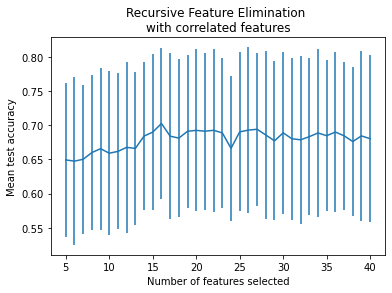

In [101]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [102]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.704190,0.015589
Accuracy_train,0.978164,0.001539
F1 Score,0.731079,0.014342
Precision,0.723033,0.017179
Recall,0.757500,0.018838
Roc_auc,0.791029,0.015862


In [103]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './Models/XGB.pkl')
XGB= joblib.load(filename='./Models/XGB.pkl')

In [104]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./Original data/X_test_data.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,MATS3p,SM10_AEA(dm),GATS7s,B09[O-O],CATS2D_06_DL,P_VSA_charge_7,VE1sign_B(p),MATS3m,P_VSA_LogP_5,P_VSA_LogP_4,Mv,MATS2m,MATS2p,CATS2D_05_DA,GATS2p,C-016
cid,,,,,,,,,,,,,,,,
5273,0.148099,0.279629,0.937287,0.0,0.25,0.055154,0.063176,0.630087,0.375852,0.294068,0.534972,0.369317,0.839555,-0.166667,0.120946,0.0
13463,0.167609,0.382490,0.371194,0.0,0.00,0.000000,0.003349,0.577077,0.175482,0.415638,0.843058,-0.145355,0.534014,0.166667,0.224814,0.0
39148,0.082452,0.442684,0.247689,0.0,0.00,0.365425,-0.032536,0.522655,0.218782,0.415638,0.386171,0.490001,1.437855,0.500000,-0.226505,0.0
56328,0.345941,0.338437,0.498540,0.0,0.00,0.000000,-0.036314,0.555061,0.175482,0.415638,0.689307,0.185979,0.786846,0.000000,0.189035,0.0
67358,0.202511,0.471826,0.577994,0.0,0.00,0.000000,0.352888,0.673856,0.175482,0.322354,0.650332,0.151812,0.729538,0.500000,0.423568,0.0


In [105]:
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of not gelable','Probability of gelable'])

Predicted_data

,Probability of not gelable,Probability of gelable
0,0.744965,0.255035
1,0.032582,0.967418
2,0.801961,0.198039
3,0.384812,0.615188
4,0.497980,0.502020
...,...,...
7252,0.734936,0.265064
7253,0.220765,0.779235
7254,0.240419,0.759581
7255,0.695719,0.304281


In [107]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of not gelable','Probability of gelable'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of gelable" , inplace=True, ascending=False)
Predicted_data.to_csv("./Results/XGB_predict_data.csv",sep=',')
Predicted_data.head()

,Probability of not gelable,Probability of gelable
cid,,
5271957,0.000417,0.999583
71302469,0.000602,0.999398
122130330,0.000602,0.999398
5271955,0.000703,0.999297
150667,0.000707,0.999293


In [110]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./Results/XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./Results/XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.634476  0.014766  0.638667  0.015374  0.650762  0.012548   
Accuracy_train  0.978164  0.001539  0.978164  0.001539  0.978164  0.001539   
F1 Score        0.669811  0.015074  0.667694  0.014479  0.673582  0.014725   
Precision       0.655102  0.015993  0.669162  0.016666  0.682875  0.013735   
Recall          0.710714  0.022896  0.692143  0.022529  0.696429  0.021824   
Roc_auc         0.691531  0.020388  0.721259  0.016294  0.745867  0.016605   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.704190  0.015589  
Accuracy_train  0.978164  0.001539  
F1 Score        0.731079  0.014342  
Precision       0.723033  0.017179  
Recall          0.757500  0.018838  
Roc_auc         0.791029  0.015862

In [109]:
#Feature Importance
XGB= joblib.load(filename='./Models/XGB.pkl')
result = permutation_importance(
    XGB, X_XGB, y, n_repeats=1000, random_state=0, n_jobs=2)
clf2_importances = pd.Series(result.importances_mean, index= columns)
importances_mean=pd.DataFrame(clf2_importances, index=columns)
importances_std=pd.DataFrame(result.importances_std, index=columns)
importances_se=pd.DataFrame(result.importances_std/math.sqrt(10), index=columns)
importances_=pd.concat([importances_mean,importances_std,importances_se],axis=1)
importances_.columns=["mean","std","se"]
Feature_importance=importances_.sort_values(by="mean",ascending=True)
Feature_importance.columns=[['XGBoost']*3,["mean","std","se"]]
Feature_importance.columns.names=['Method','Values']
Feature_importance.to_csv('./Results/XGB_feature_importance.csv',encoding='utf-8')
Feature_importance

Method           XGBoost                    
Values              mean       std        se
P_VSA_LogP_4    0.000014  0.003181  0.001006
MATS2p          0.000282  0.009232  0.002919
MATS2m          0.002873  0.012410  0.003924
CATS2D_05_DA    0.003366  0.014335  0.004533
CATS2D_06_DL    0.007746  0.012145  0.003840
SM10_AEA(dm)    0.007873  0.015134  0.004786
C-016           0.010887  0.005900  0.001866
MATS3m          0.012901  0.017036  0.005387
GATS7s          0.015183  0.009405  0.002974
B09[O-O]        0.016141  0.014736  0.004660
P_VSA_charge_7  0.016746  0.012417  0.003927
P_VSA_LogP_5    0.020549  0.017469  0.005524
Mv              0.021817  0.015154  0.004792
GATS2p          0.039648  0.018205  0.005757
VE1sign_B(p)    0.049113  0.024133  0.007631
MATS3p          0.069225  0.026893  0.008504